In [3]:
# General imports
#import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import MeanSquaredError, MeanSquaredLogarithmicError
from tensorflow.keras.optimizers import Adam
import pydot
import tensorflow as tf
import os
from pathlib import Path
import pandas as pd

from sklearn.metrics import mean_squared_log_error, mean_squared_error
import xgboost as xgb

# Project imports
from utils.images_loader import ImagesLoader
from utils.text_data_loader import TextDataLoader
from utils.utilities import plot_history
from utils.utilities import rmsle
from model import TextOnlyModel, ImageAndTextModel
from train import load_x_y_from_loaders
from train import IMAGE_INPUT_NAME, TEXT_FEATURES_INPUT_NAME, OUTPUT_NAME





In [4]:

# Params
use_scaling = True
include_images = True

# data paths
train_text_path = r'./src_data/train.csv'
train_images_folder = r'./src_data/train_profile_images'
test_text_path = r'./src_data/test.csv'
test_images_folder = r'./src_data/test_profile_images'
log_folder = 'logs'

In [5]:
# TRAIN
# Images loader
print('\nTRAIN:')
images_loader = ImagesLoader(src_folder_path = train_images_folder)
print('Number images: {:}'.format(images_loader.nbr_images))
print('Images shape: {:}'.format(images_loader.image_shape))
# Text data loader
text_data_loader = TextDataLoader(src_csv_file_path = train_text_path)

# TEST
# Test Images loader
print('\nTEST:')
test_images_loader = ImagesLoader(src_folder_path = test_images_folder)
print('Number images: {:}'.format(test_images_loader.nbr_images))
print('Images shape: {:}'.format(test_images_loader.image_shape))
# Test Text data loader
test_text_data_loader = TextDataLoader(src_csv_file_path = test_text_path)


# Get and profile by its ID
profile_id = '00NJOGS399G79OP3'
image_data = images_loader.get_image_data_for_profile_id(profile_id)
text_data = text_data_loader.get_orig_data_for_profile_id(profile_id)




TRAIN:
Number images: 7500
Images shape: (32, 32, 3)

TEST:
Number images: 2500
Images shape: (32, 32, 3)


In [6]:

# Print data for this profile
#print(text_data)

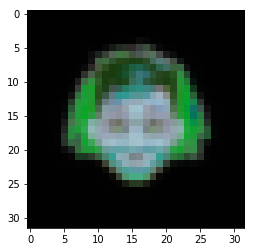

In [7]:
# Show profile image
plt.imshow(image_data)
plt.show()

In [7]:
'''
def load_x_y_from_loaders(images_loader, text_data_loader, profiles_ids_list=None, include_images=False):
    likes = None

    # If profiles_ids_list not provided fetch all profiles_ids in text data loader
    if profiles_ids_list is None:
        profiles_ids_list = text_data_loader.get_transformed_features()['Id'].values

    # Retunr X and y
    images = np.array([images_loader.get_image_data_for_profile_id(profile_id) for profile_id in profiles_ids_list])
    features = text_data_loader.get_transformed_features()
    features = features[features['Id'].isin(profiles_ids_list)]
    if 'Num of Profile Likes' in features:
        likes = features['Num of Profile Likes']
        likes = np.array(likes)
        features = features.drop(columns =['Id', 'Num of Profile Likes'])
    else:
        features = features.drop(columns =['Id'])
    features = np.array(features)
    
    if include_images:
        X = {IMAGE_INPUT_NAME: images, # Images
             TEXT_FEATURES_INPUT_NAME: features} # Transformed Text Features
    else:
        X = {TEXT_FEATURES_INPUT_NAME: features} # Transformed Text Features
    
    if likes is not None:
        y = {OUTPUT_NAME: likes} # Likes
        return X, y
    
    return X
'''
    

In [8]:
# -- Split ids to train/valid --
all_profiles_ids_list = text_data_loader.get_transformed_features()['Id'].values

train_profiles_ids, valid_profiles_ids = train_test_split(all_profiles_ids_list, test_size = .2, random_state=5, shuffle=True)


In [9]:
# -- Preare data for model  Train/Valid--
# Will use a dict to associate the corresponding data to the right input in the model (Image vs Features)

# TODO DEBUG using scaling for tests
if use_scaling:
    sc_x = StandardScaler()
    sc_y = StandardScaler()

# - Train: use train_profiles_ids
train_X, train_y = load_x_y_from_loaders(images_loader=images_loader,
                                        text_data_loader=text_data_loader,
                                        profiles_ids_list=train_profiles_ids,
                                        include_images=include_images)
if use_scaling:
    # Fit and Transform on Train
    train_X[TEXT_FEATURES_INPUT_NAME] = sc_x.fit_transform(train_X[TEXT_FEATURES_INPUT_NAME])
    train_y[OUTPUT_NAME] = sc_y.fit_transform(train_y[OUTPUT_NAME].reshape(-1, 1))

# - Valid: use valid_profiles_ids
valid_X, valid_y = load_x_y_from_loaders(images_loader=images_loader,
                             text_data_loader=text_data_loader,
                             profiles_ids_list=valid_profiles_ids,
                             include_images=include_images)

if use_scaling:
    # Transform only on Valid
    valid_X[TEXT_FEATURES_INPUT_NAME] = sc_x.transform(valid_X[TEXT_FEATURES_INPUT_NAME])
    valid_y[OUTPUT_NAME] = sc_y.transform(valid_y[OUTPUT_NAME].reshape(-1, 1))


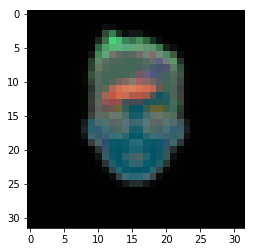

In [10]:
idx = 10

#vX, valid_X
#vy, valid_y
plt.imshow(train_X[IMAGE_INPUT_NAME][idx])
plt.show()


In [11]:
# -- Preare data for model  All DATA and TEST --

all_data_profiles_ids_list = text_data_loader.get_transformed_features()['Id'].values
all_test_profiles_ids_list = test_text_data_loader.get_transformed_features()['Id'].values


# TODO DEBUG using scaling for tests
if use_scaling:
    sc_alldata_x = StandardScaler()
    sc_alldata_y = StandardScaler()

#- All Train data
data_X, data_y = load_x_y_from_loaders(images_loader=images_loader,
                             text_data_loader=text_data_loader,
                             profiles_ids_list=all_data_profiles_ids_list,
                             include_images=True)
if use_scaling:
    # Fit and Transform on Train
    data_X[TEXT_FEATURES_INPUT_NAME] = sc_alldata_x.fit_transform(data_X[TEXT_FEATURES_INPUT_NAME])
    data_y[OUTPUT_NAME] = sc_alldata_y.fit_transform(data_y[OUTPUT_NAME].reshape(-1, 1))


#- Test data
test_X = load_x_y_from_loaders(images_loader=test_images_loader,
                             text_data_loader=test_text_data_loader,
                             profiles_ids_list=all_test_profiles_ids_list,
                             include_images=True)
if use_scaling:
    # Transform only on Test
    test_X[TEXT_FEATURES_INPUT_NAME] = sc_alldata_x.fit_transform(test_X[TEXT_FEATURES_INPUT_NAME])


In [12]:
all_test_profiles_ids_list

array(['49I3SOKLI2CMNGP4', '727IRIR59A3P88LK', 'LN95SD15SRPCEE8F', ...,
       'SRNIBIK27BQ2M3PB', '6CP232J9R8N84702', 'AROR24MH3M79EHBS'],
      dtype=object)

(32, 32, 3)
[0.11579698]
(32, 32, 3)


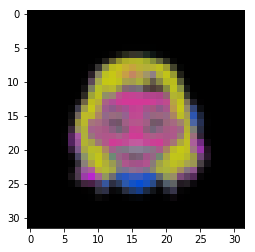

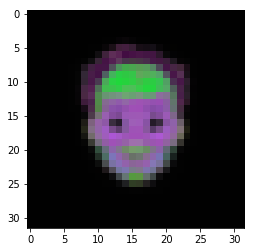

In [13]:
idx = 0
print(train_X[IMAGE_INPUT_NAME][idx].shape)
print(train_y[OUTPUT_NAME][idx])
print(test_X[IMAGE_INPUT_NAME][idx].shape)

plt.imshow(train_X[IMAGE_INPUT_NAME][idx])
plt.show()

plt.imshow(test_X[IMAGE_INPUT_NAME][idx])
plt.show()



In [16]:
# Keras models


# Need to reload model.py in case of changes
import imp
import model
imp.reload(model)
from model import TextOnlyModel, ImageAndTextModel

# GPU specific
os.environ['CUDA_VISIBLE_DEVICES']='1'
# Hyper-params TODO move to json file? for better modularity and tracking
learning_rate = 0.001
training_batch_size = 256 #32
n_epochs = 100



# -- Prepare model --
image_height = images_loader.image_shape[0]
image_width = images_loader.image_shape[1]
image_nbr_channels = images_loader.image_shape[2]
nbr_text_features = train_X[TEXT_FEATURES_INPUT_NAME].shape[1] # TODO text_data_loader.get_nbr_features()


# Text and Image model
if include_images:
    model = ImageAndTextModel(image_height = image_height,
                            image_width = image_width,
                            image_nbr_channels = image_nbr_channels,
                            nbr_text_features = nbr_text_features,
                            image_input_name=IMAGE_INPUT_NAME,
                            text_features_input_name=TEXT_FEATURES_INPUT_NAME,
                            output_name=OUTPUT_NAME)

# Text only model
else :
    model = TextOnlyModel(nbr_text_features = nbr_text_features,
                            text_features_input_name=TEXT_FEATURES_INPUT_NAME,
                            output_name=OUTPUT_NAME)

# Model summary
model.summary() # TODO model summary to file
plot_model(model, os.path.join(log_folder, 'model.png'), show_shapes=True)

# -- Compile model --
model.compile(loss=MeanSquaredLogarithmicError(), #MeanSquaredError(),
                optimizer=Adam(lr=learning_rate),
                metrics=['mean_squared_error', 'mean_squared_logarithmic_error'])



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
text_features (InputLayer)      [(None, 37)]         0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 8)    224         image[0][0]                      
__________________________________________________________________________________________________
dense (Dense)                   (None, 37)           1406        text_features[0][0]              
______________________________________________________________________________________________

In [17]:
# -- Fit model --
hist = model.fit(x=train_X,
                    y=train_y,
                    batch_size = training_batch_size,
                    validation_data=(valid_X, valid_y),
                    epochs=n_epochs,
                    verbose=1)

ror: 0.1081 - val_loss: 0.0994 - val_mean_squared_error: 1.1215 - val_mean_squared_logarithmic_error: 0.0994
Epoch 23/100
5994/5994 [==============================] - 0s 78us/sample - loss: 0.1078 - mean_squared_error: 1.4354 - mean_squared_logarithmic_error: 0.1078 - val_loss: 0.0992 - val_mean_squared_error: 1.0782 - val_mean_squared_logarithmic_error: 0.0992
Epoch 24/100
5994/5994 [==============================] - 0s 78us/sample - loss: 0.1088 - mean_squared_error: 1.4612 - mean_squared_logarithmic_error: 0.1088 - val_loss: 0.0991 - val_mean_squared_error: 1.0799 - val_mean_squared_logarithmic_error: 0.0991
Epoch 25/100
5994/5994 [==============================] - 0s 80us/sample - loss: 0.1074 - mean_squared_error: 1.4599 - mean_squared_logarithmic_error: 0.1074 - val_loss: 0.0993 - val_mean_squared_error: 1.1694 - val_mean_squared_logarithmic_error: 0.0993
Epoch 26/100
5994/5994 [==============================] - 0s 79us/sample - loss: 0.1083 - mean_squared_error: 1.6051 - mean_sq

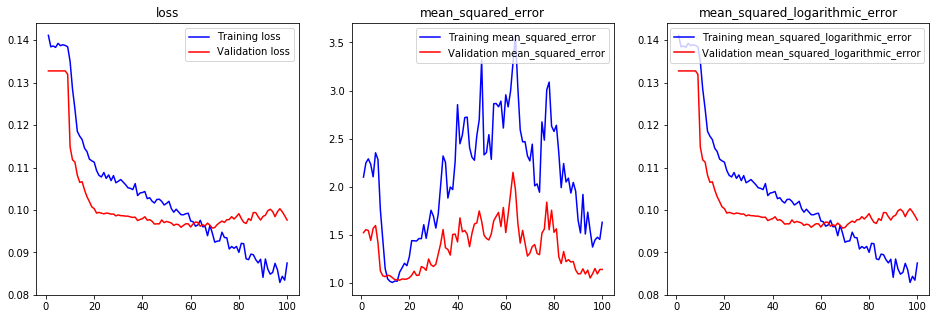

In [18]:
plot_history(hist)

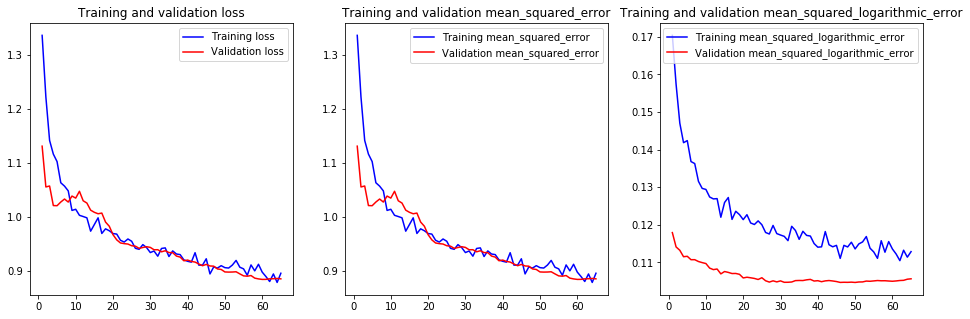

In [69]:
plot_history(hist)

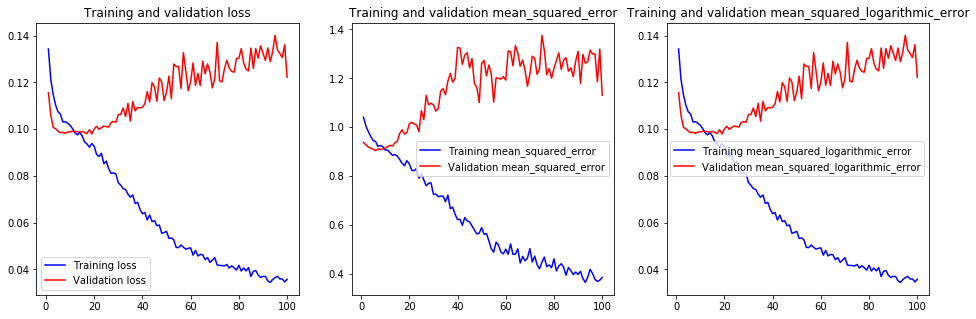

In [127]:
plot_history(hist)


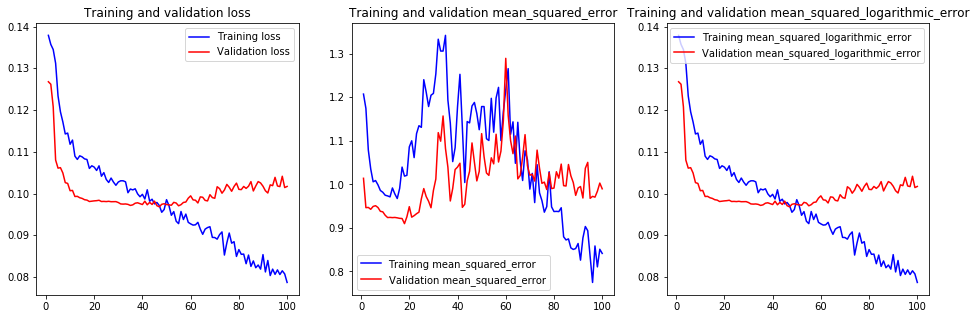

In [134]:
plot_history(hist)

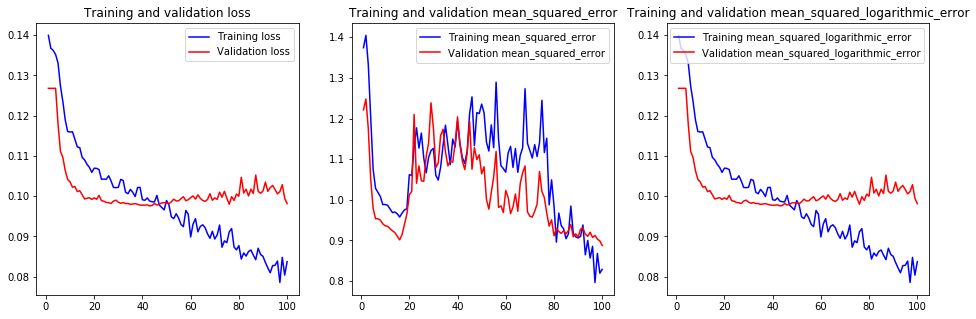

In [184]:
plot_history(hist)

In [61]:
scaled_valid_y[50]

array([4069])

In [18]:
# Evaluation
valid_pred_y = model.predict(valid_X)

# Scale predicted values back
scaled_valid_y = sc_y.inverse_transform(valid_y[OUTPUT_NAME]).astype(int)
scaled_valid_pred_y = sc_y.inverse_transform(valid_pred_y).astype(int)

# Make sure predicted and scaled back values are not negatives!
idexes = np.nonzero(scaled_valid_pred_y < 0)
scaled_valid_pred_y[idexes] = 0

# Compute rmse and rmsle
rmse_val = np.sqrt(mean_squared_error(scaled_valid_pred_y, scaled_valid_y))
print('sqrt mse: {:}'.format(rmse_val))
rmsle_val = rmsle(scaled_valid_pred_y, scaled_valid_y)
print('rmsle: {:}'.format(rmsle_val))

sqrt mse: 6441.253914261725
rmsle: 2.9762624425795785


In [56]:
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [19]:
# Prepare data for non NN models

train_values_X= train_X[TEXT_FEATURES_INPUT_NAME]
train_values_y= train_y[OUTPUT_NAME]

valid_values_X= valid_X[TEXT_FEATURES_INPUT_NAME]
valid_values_y= valid_y[OUTPUT_NAME]

print('Train shape {:}'.format(train_values_X.shape, train_values_y.shape))
print('Valid shape {:}'.format(valid_values_X.shape, valid_values_y.shape))

Train shape (5994, 37)
Valid shape (1499, 37)


In [22]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor


reg_forest = RandomForestRegressor(#n_estimators=500,
                                   random_state=42,
                                   verbose=1)

reg_forest.fit(train_values_X, train_values_y)

valid_pred_y = reg_forest.predict(valid_values_X)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [23]:
# Evaluation

# Scale predicted values back
scaled_valid_y = sc_y.inverse_transform(valid_values_y).astype(int)
scaled_valid_pred_y = sc_y.inverse_transform(valid_pred_y).astype(int)

# Make sure predicted and scaled back values are not negatives!
idexes = np.nonzero(scaled_valid_pred_y < 0)
scaled_valid_pred_y[idexes] = 0

# Compute rmse and rmsle
rmse_val = np.sqrt(mean_squared_error(scaled_valid_pred_y, scaled_valid_y))
print('sqrt mse: {:}'.format(rmse_val))
rmsle_val = rmsle(scaled_valid_pred_y, scaled_valid_y)
print('rmsle: {:}'.format(rmsle_val))

sqrt mse: 7350.350234901542
rmsle: 2.331698754354656


In [91]:
# -- Train on all data and predict on test set --
# RANDOM FOREST using Text features only
alldataset_X= data_X[TEXT_FEATURES_INPUT_NAME]
alldataset_y= data_y[OUTPUT_NAME]

testset_X= test_X[TEXT_FEATURES_INPUT_NAME]

print('Train shape {:}'.format(alldataset_X.shape, alldataset_y.shape))
print('Valid shape {:}'.format(testset_X.shape))

# Train Random Forest
from sklearn.ensemble import RandomForestRegressor
reg_forest = RandomForestRegressor(random_state=42,
                                   verbose=1)
reg_forest.fit(alldataset_X, alldataset_y)

# Predict on Test set
test_pred_y = reg_forest.predict(testset_X)

# Scale predicted values to int
scaled_test_pred_y = sc_alldata_y.inverse_transform(test_pred_y).astype(int)

# Make sure predicted and scaled back values are not negatives!
idexes = np.nonzero(scaled_test_pred_y < 0)
scaled_test_pred_y[idexes] = 0


Train shape (7493, 37)
Valid shape (2500, 37)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [93]:
testset_X
#scaled_test_pred_y

array([[ 0.55818465, -0.32478969,  0.84955114, ..., -0.17675236,
        -0.1876985 , -0.14581528],
       [-1.79152186, -0.32478969,  0.84955114, ..., -0.17675236,
        -0.1876985 , -0.14581528],
       [ 0.55818465, -0.32478969,  0.84955114, ..., -0.17675236,
        -0.1876985 , -0.14581528],
       ...,
       [-1.79152186, -0.32478969,  0.84955114, ...,  5.65763295,
        -0.1876985 , -0.14581528],
       [ 0.55818465, -0.32478969, -1.17709218, ..., -0.17675236,
        -0.1876985 , -0.14581528],
       [ 0.55818465, -0.32478969, -1.17709218, ..., -0.17675236,
        -0.1876985 , -0.14581528]])

In [95]:
scaled_test_pred_y

array([ 6215,  9907, 12186, ...,  4357,  2414,  3538])

In [94]:
all_test_profiles_ids_list

array(['49I3SOKLI2CMNGP4', '727IRIR59A3P88LK', 'LN95SD15SRPCEE8F', ...,
       'SRNIBIK27BQ2M3PB', '6CP232J9R8N84702', 'AROR24MH3M79EHBS'],
      dtype=object)

In [100]:
# Store in DataFrame and save predictions
test_pd = pd.DataFrame()
test_pd['Id'] = all_test_profiles_ids_list
test_pd['NumProfileLikes'] = scaled_test_pred_y

test_tosubmit_folder = os.path.join(log_folder,'v0')
# Create log folder if does not exist
if not Path(test_tosubmit_folder).exists():
    os.mkdir(test_tosubmit_folder)
test_name = 'RandomForestRegressor-rstate42-gitversion-xxxx-2020-11-26'
test_pd.to_csv(os.path.join(test_tosubmit_folder, test_name+'.csv'), sep=',', index=False)

In [219]:
# Fit xgboost
if 0:
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                                max_depth=500,
                                n_estimators=100,
                                random_state=42)
    xgb_model.fit(tr_X, tr_y, eval_set=[(val_X, val_y)])

    val_pred_y = xgb_model.predict(val_X)


sqrt mse: 7191.01299905897
rmsle: 1.9445262395719183


In [44]:
scaled_valid_pred_y.shape

(1499,)

In [64]:
scaled_valid_pred_y.min()

0